In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import glob
import scipy.stats as sts
import ast
from scipy.interpolate import interp1d
from collections import OrderedDict
from matplotlib.transforms import blended_transform_factory

plt.close('all')
plt.style.use('default')
plt.rc('font', family='serif')
plt.rc('text', usetex=True)

LEGEND_FONT_SIZE = 12
AXIS_FONT_SIZE = 16
TICKS_FONT_SIZE = 12

figs = []

def running_mean(x, N):
    divider = np.convolve(np.ones_like(x), np.ones((N,)), mode='same')
    return np.convolve(x, np.ones((N,)), mode='same') / divider

In [12]:
linestyles = OrderedDict(
    [('solid',               (0, ())),
     ('loosely dotted',      (0, (1, 10))),
     ('dotted',              (0, (1, 5))),
     ('densely dotted',      (0, (1, 1))),

     ('loosely dashed',      (0, (5, 10))),
     ('dashed',              (0, (5, 5))),
     ('densely dashed',      (0, (5, 1))),

     ('loosely dashdotted',  (0, (3, 10, 1, 10))),
     ('dashdotted',          (0, (3, 5, 1, 5))),
     ('densely dashdotted',  (0, (3, 1, 1, 1))),

     ('loosely dashdotdotted', (0, (3, 10, 1, 10, 1, 10))),
     ('dashdotdotted',         (0, (3, 5, 1, 5, 1, 5))),
     ('densely dashdotdotted', (0, (3, 1, 1, 1, 1, 1))),

     ('loosely dashdashdotted', (0, (3, 10, 3, 10, 1, 10))),
     ('dashdashdotted',         (0, (3, 5, 3, 5, 1, 5))),
     ('densely dashdashdotted', (0, (3, 1, 3, 1, 1, 1)))])

ls = [linestyles['solid'], linestyles['dashed'], linestyles['dotted'], 
      linestyles['dashdotted'], linestyles['dashdotdotted'], linestyles['dashdashdotted'],
      linestyles['densely dashed'], linestyles['densely dotted']]

col = ['r', 'b', 'g', 'y', 'orange', 'purple', 'c', 'k']

In [13]:
def plot_ci(xs, ys, conf, n, xlabel=None, ylabel=None, label=None, ax=None, **kwargs):
    
    if np.array(xs).ndim > 1:
        all_x = np.array(list(set(np.concatenate(xs).ravel().tolist())))
        all_x = np.sort(all_x)
        last_x = min(map(lambda x: max(x), xs))
        first_x = max(map(lambda x: min(x), xs))
        all_ys = []

        pred_x = np.linspace(first_x, last_x, 200)

        for i in range(len(xs)):
            f = interp1d(xs[i], ys[i], "linear")
            all_ys.append(f(pred_x))
        all_ys = np.array(all_ys)
    else:
        all_x = xs
        all_ys = ys
        pred_x = xs
    
    data_mean = np.mean(all_ys, axis=0)
    data_std = np.std(all_ys, axis=0) + 1e-24
    interval = sts.t.interval(conf, n-1,loc=data_mean,scale=data_std/np.sqrt(n))

    col = kwargs.get('color')
    if ax is None:
        fig, ax = plt.subplots(figsize=(4.8, 3.2))
        figs.append(fig)
    if label is None:
        ax.plot(pred_x, data_mean, **kwargs)
    else:
        ax.plot(pred_x, data_mean, label=label, **kwargs)
        
    if col is not None:
        ax.fill_between(pred_x, interval[0], interval[1], alpha=0.2, color=col, linewidth=0.)
    else:
        ax.fill_between(pred_x, interval[0], interval[1], alpha=0.2, linewidth=0.)
        
    if xlabel is not None:
        ax.set_xlabel(xlabel, fontsize=AXIS_FONT_SIZE)
    if ylabel is not None:
        ax.set_ylabel(ylabel, fontsize=AXIS_FONT_SIZE)
    return ax

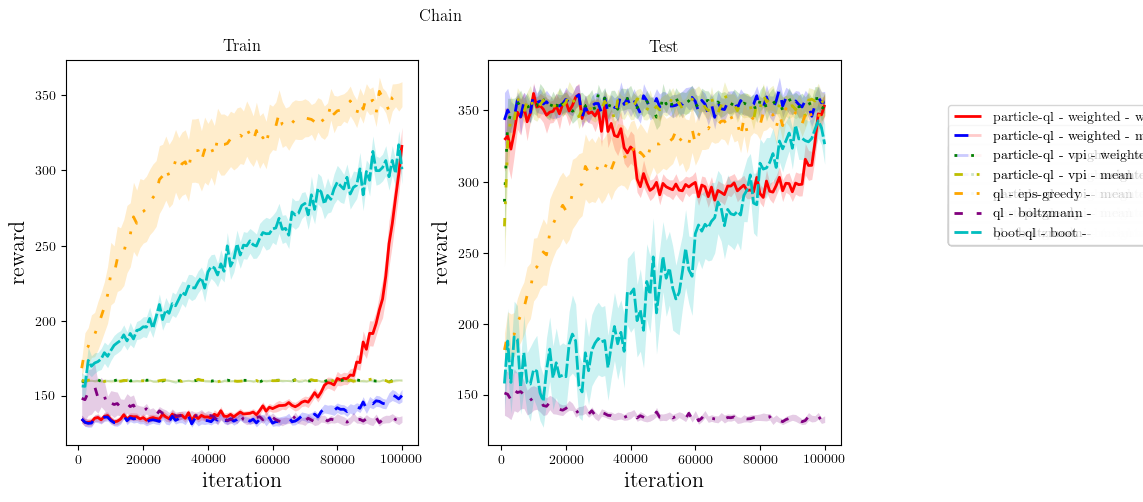

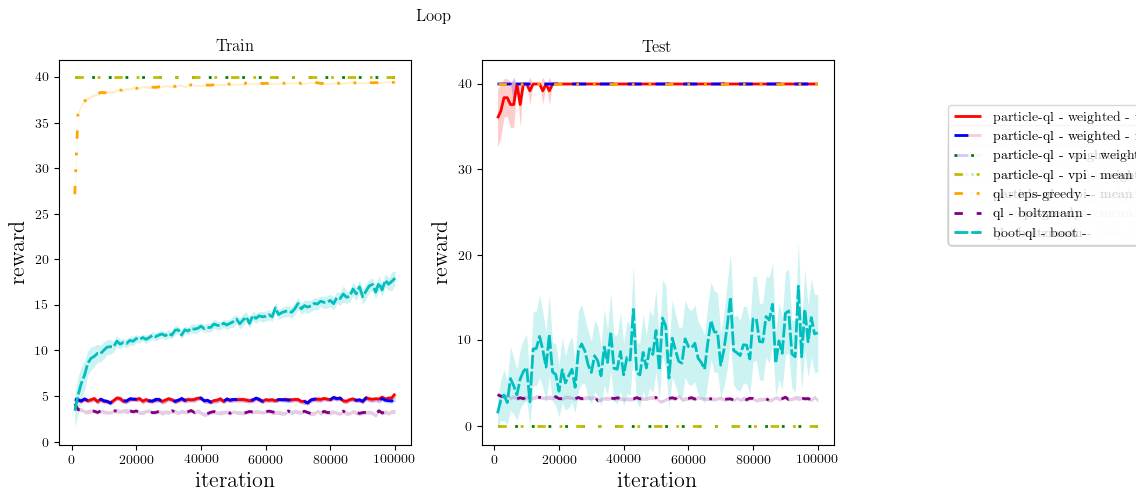

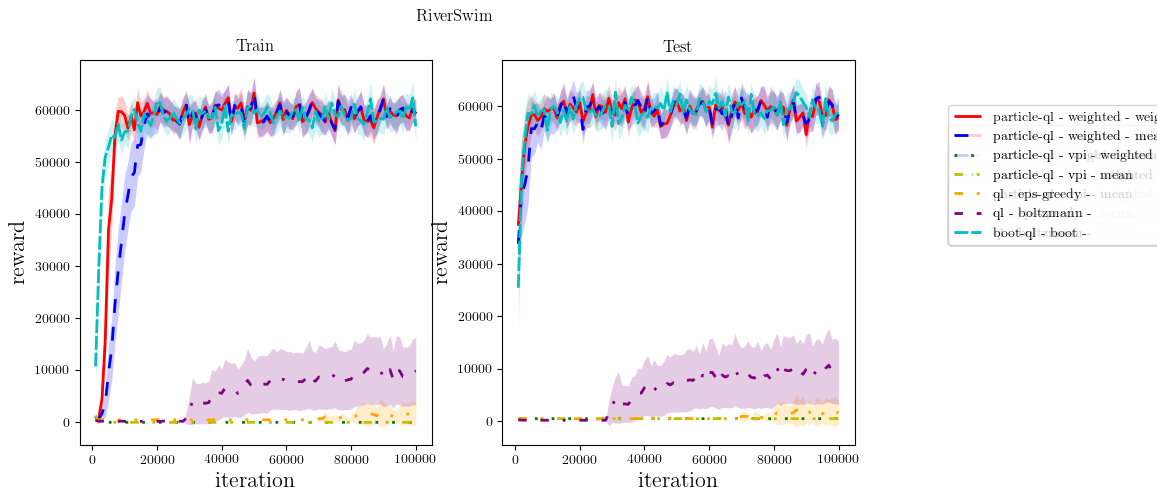

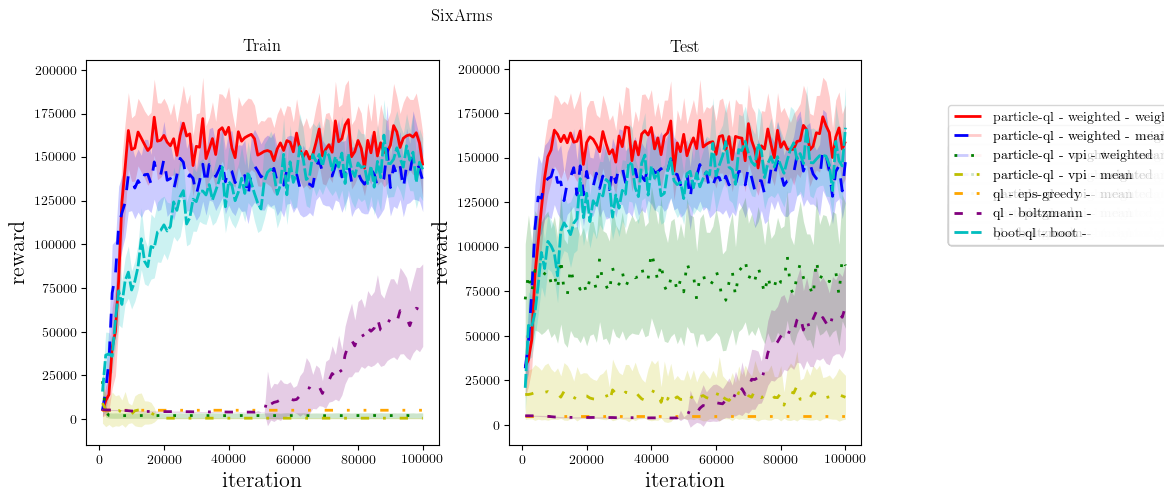

In [17]:
environments = ['Chain', 'Loop', 'RiverSwim', 'SixArms']
algorithms = ['particle-ql', 'ql', 'boot-ql']
policies = [['weighted', 'vpi'], ['eps-greedy', 'boltzmann'], ['boot']] 
updates = [['weighted', 'mean'], [''], ['']]
conf = 0.95

for env in environments:
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    fig.suptitle(env)
    i = 0    
    for j, alg in enumerate(algorithms):
        for pi in policies[j]:
            for u in updates[j]:
                paths = glob.glob("./data/" + env + "/" + alg + "/results_" + pi + "_*_" + u + "*.npy")
                #print(paths)
                for p in paths:
                    results = np.load(p)
                    #print(results.shape)
                    n_runs = results.shape[0]

                    timesteps = np.cumsum(results[:, 0, :, 0][0])
                    cum_reward_train = results[:, 0, :, 3]
                    cum_reward_test = results[:, 1, :, 3]

                    #print(cum_reward_test)
                    ax[0].set_title('Train')
                    ax[0] = plot_ci(timesteps,cum_reward_train, conf, 
                                    n_runs, xlabel='iteration', ylabel='reward', label=alg + " - " + pi + " - " + u,
                                    ax=ax[0], linewidth=2.0, linestyle=ls[i], color=col[i])

                    ax[1].set_title('Test')
                    ax[1] = plot_ci(timesteps, cum_reward_test, conf, 
                                    n_runs, xlabel='iteration', ylabel='reward', 
                                    ax=ax[1], linewidth=2.0, linestyle=ls[i], color=col[i])

                    fig.legend(loc='lower right', bbox_to_anchor=(1.2, 0.5))

                    i += 1




